# IMU only training notebook

### 1: import IMU-only data

In [1]:
# import variables
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# scaled data
train_IMU_scaled = np.load('../variables/train_IMU_scaled.npy')
test_IMU_scaled = np.load('../variables/test_IMU_scaled.npy')
val_IMU_scaled = np.load('../variables/val_IMU_scaled.npy')

# unscaled data
train_IMU_prescaled = pd.read_pickle('../variables/train_IMU_prescaled.pkl')
test_IMU_prescaled = pd.read_pickle('../variables/test_IMU_prescaled.pkl')
val_IMU_prescaled = pd.read_pickle('../variables/val_IMU_prescaled.pkl')

In [2]:
# Display the 13 feature names for the training data
print("Training/Validation features:")
print(train_IMU_prescaled.columns.to_list())

# Display the 12 feature names for the test data
print("\nTest features:")
print(test_IMU_prescaled.columns.to_list())

Training/Validation features:
['sequence_id', 'gesture', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'acc_mag', 'lin_acc_mag', 'acc_mag_jerk', 'lin_acc_mag_jerk', 'rot_angle', 'angular_distance', 'rot_angle_vel', 'angular_vel_x', 'angular_vel_y', 'angular_vel_z']

Test features:
['sequence_id', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'acc_mag', 'lin_acc_mag', 'acc_mag_jerk', 'lin_acc_mag_jerk', 'rot_angle', 'angular_distance', 'rot_angle_vel', 'angular_vel_x', 'angular_vel_y', 'angular_vel_z']


In [3]:
# Find the index of the 'gesture' column
column_list = train_IMU_prescaled.columns.to_list()
gesture_index = column_list.index('gesture')

print(f"The 'gesture' column is at index: {gesture_index}")

The 'gesture' column is at index: 1


### 2: sequence data

In [ ]:
train_IMU_prescaled = train_IMU_prescaled.reset_index(drop=True)
test_IMU_prescaled = test_IMU_prescaled.reset_index(drop=True)
val_IMU_prescaled = val_IMU_prescaled.reset_index(drop=True)

# sequence train data
grouped_train = train_IMU_prescaled.groupby('sequence_id')
sequences_train = []
labels_train = []
for sequence_id, group in grouped_train:
    indices_train = group.index.to_list()
    # Get all 13 features
    current_sequence_data = train_IMU_scaled[indices_train]
    # NEW: Select all features *except* the one at index 1 ('gesture')
    features_only = np.delete(current_sequence_data, 1, axis=1)
    sequences_train.append(features_only)
    
    label_train = group['gesture'].iloc[0]
    labels_train.append(label_train)

# sequence test data
grouped_test = test_IMU_prescaled.groupby('sequence_id')
sequences_test = []
for sequence_id, group in grouped_test:
    indices_test = group.index.to_list()
    # This data is already 12 features, so no change is needed
    current_sequence = test_IMU_scaled[indices_test]
    sequences_test.append(current_sequence)

# sequence val data
grouped_val = val_IMU_prescaled.groupby('sequence_id')
sequences_val = []
labels_val = []
for sequence_id, group in grouped_val:
    indices_val = group.index.to_list()
    # Get all 13 features
    current_sequence_data = val_IMU_scaled[indices_val]
    # NEW: Select all features *except* the one at index 1 ('gesture')
    features_only = np.delete(current_sequence_data, 1, axis=1)
    sequences_val.append(features_only)
    
    label_val = group['gesture'].iloc[0]
    labels_val.append(label_val)

In [5]:
# pad data
def pad_data(sequences, max_length=None):
    padded_sequences = pad_sequences(sequences, padding='post', dtype='float32', maxlen=700)
    return padded_sequences

train_padded = pad_data(sequences_train)
test_padded = pad_data(sequences_test)
val_padded = pad_data(sequences_val)

y_train = np.array(labels_train)
y_val = np.array(labels_val)

print("Shape of the final padded data:", train_padded.shape) 
print("Shape of the final padded data:", test_padded.shape) 
print("Shape of the final padded data:", val_padded.shape) 

Shape of the final padded data: (7920, 700, 12)
Shape of the final padded data: (2, 700, 12)
Shape of the final padded data: (1584, 700, 12)


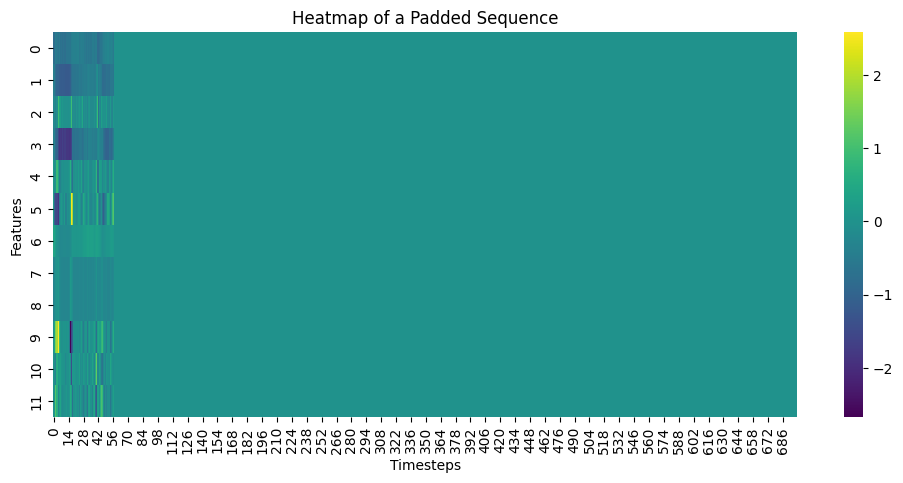

In [6]:
# select a sample to view (e.g., the first one)
sample_to_view = train_padded[0]

# create the heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(sample_to_view.T, cmap='viridis')
plt.title('Heatmap of a Padded Sequence')
plt.xlabel('Timesteps')
plt.ylabel('Features')
plt.show()

In [7]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [8]:
# 1. Initialize and fit the encoder ONLY on the training data
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# 2. Transform all three sets using the learned mapping
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

In [9]:
dummy_clf.fit(train_padded, y_train)

,strategy,'most_frequent'
,random_state,None
,constant,None


In [10]:
# 3. Make predictions on the validation set
y_val_pred_dummy = dummy_clf.predict(val_padded)

# 4. Calculate and print the baseline accuracy
baseline_accuracy = accuracy_score(y_val, y_val_pred_dummy)

print(f"Baseline (Most Frequent) Accuracy: {baseline_accuracy * 100:.2f}%")

Baseline (Most Frequent) Accuracy: 7.64%


In [ ]:
num_timesteps = 700 
num_features = 12
num_classes = 18

model = tf.keras.Sequential([
    
    # ----------------------------------------------------------------------
    # LAYER 1: The "Quality Control" (Masking) Layer
    # Job: Finds all the 0.0 values from padding and tells the model
    # to ignore them, so it only learns from the *real* sequence data.
    # ----------------------------------------------------------------------
    tf.keras.layers.Masking(
        mask_value=0., 
        input_shape=(num_timesteps, num_features)
    ),
    
    # ----------------------------------------------------------------------
    # LAYER 2: The "Pattern Scanners" (Convolutional) Layer
    # Job: Scans the sequences to find short, local patterns.
    # filters=64: Hires 64 different "scanners" to look for 64 patterns.
    # kernel_size=3: Each scanner looks at 3 timesteps at a time.
    # activation='relu': A standard function that helps the model learn.
    # ----------------------------------------------------------------------
    tf.keras.layers.Conv1D(
        filters=64, 
        kernel_size=3, 
        activation='relu'
    ),
    
    # ----------------------------------------------------------------------
    # LAYER 3: The "Shift Manager" (Pooling) Layer
    # Job: Summarizes the findings of the 64 "scanners" from Layer 2.
    # It finds the *single strongest signal* each scanner found
    # over the entire sequence. This reduces the data size and makes
    # the model not care *when* the pattern happened, just *that* it happened.
    # ----------------------------------------------------------------------
    tf.keras.layers.GlobalMaxPooling1D(),
    
    # ----------------------------------------------------------------------
    # LAYER 4: The "Final Decision" (Output) Layer
    # Job: Takes the 64 "strongest signals" from the pooling layer
    # and "votes" on which of the 18 gestures it is.
    # activation='softmax': Converts the votes into probabilities for
    # each class (e.g., "70% 'Standing', 20% 'Walking', ...").
    # ----------------------------------------------------------------------
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Print the model's blueprint to confirm all the layers
model.summary()

/opt/miniconda3/envs/ds_env/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/miniconda3/envs/ds_env/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 700, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 698, 64)        │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,538 (13.82 KB)

 Trainable params: 3,538 (13.82 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# --- Configure the "Learning Process" ---

model.compile(
    
    # ----------------------------------------------------------------------
    # 1. The "Teacher" (Optimizer)
    # Job: The algorithm that updates the model's weights (learns)
    # after seeing how wrong its predictions were.
    # 'adam': A highly effective and popular default choice. It's an
    # efficient teaching method that adapts its learning rate as it goes.
    # ----------------------------------------------------------------------
    optimizer='adam',
    
    # ----------------------------------------------------------------------
    # 2. The "Grading Rubric" (Loss Function)
    # Job: Calculates a single number (the "loss") that quantifies
    # *how wrong* the model's prediction was. The optimizer's goal
    # is to get this number as low as possible.
    # 'sparse_categorical_crossentropy': This is the correct choice
    # because you have 18 different classes (multi-class classification)
    # and your labels (y_train) are simple integers (0, 1, 2, ...).
    # ----------------------------------------------------------------------
    loss='sparse_categorical_crossentropy',
    
    # ----------------------------------------------------------------------
    # 3. The "Report Card" (Metrics)
    # Job: The human-readable score we use to judge the model's
    # performance. While the 'loss' guides the optimizer, the
    # 'accuracy' is what we will watch.
    # 'accuracy': Simply answers "What percentage of the time did
    # the model guess the single correct answer?" We will compare
    # this to our 7.64% baseline.
    # ----------------------------------------------------------------------
    metrics=['accuracy']
)

# This command doesn't print anything, but it configures the model
# internally. We are now ready for the next step: training.

In [13]:

# 1. Initialize and fit the encoder ONLY on the training data
# This learns the mapping (e.g., "Standing"=0, "Walking"=1, etc.)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# 2. Transform all three sets using the learned mapping
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

print("Labels successfully encoded.")

Labels successfully encoded.


In [14]:
# --- Define the "Supervisor" (Callbacks) ---

# A callback to stop training early if performance on the 
# validation set stops improving. This prevents "overfitting."
# - monitor='val_loss': Watch the 'practice test' loss.
# - patience=5: Allow it to stop improving for 5 epochs
#   before stopping the training.
# - restore_best_weights=True: Once stopped, restore the
#   model weights from the *best* performing epoch.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)


# --- Start Training ---
# This is where the model studies, is graded, and is improved.
print("Starting model training...")

history = model.fit(
    
    # 1. The "Study Material" (Training Data)
    # The 7920 sequences of 12 features.
    train_padded, 
    y_train_encoded,
    
    # 2. The "Study Session" (Epochs & Batch Size)
    # epochs=50: The model will "study" the *entire* dataset 50 times.
    # (But EarlyStopping will likely stop it before then!)
    # batch_size=32: The model studies 32 samples at a time
    # before its grades are tallied and it's updated.
    epochs=50, 
    batch_size=32,
    
    # 3. The "Practice Test" (Validation Data)
    # After each epoch, the model is tested on this data, which
    # it has *not* trained on. This is how we check if it's
    # *actually* learning or just memorizing.
    validation_data=(val_padded, y_val_encoded),
    
    # 4. The "Supervisor" (Callbacks)
    # We pass in our EarlyStopping rule here.
    callbacks=[early_stopping]
)

print("Training complete.")

Starting model training...
Epoch 1/50


/opt/miniconda3/envs/ds_env/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


: 

## Step 1: Define the Model Architecture

## Step 2: Compile the Model

## Step 3: Train the Model

## Step 4: Evaluate the Model

## TODO

- get a prediction (and evaluate accuracy), comparing with dummy (read up on dummy classifier prediction...)
- tweak parameters and experiment, filter counts, etc.
- run through CNN more than once?
- model tuning
- final evaluation (using Kaggle evaluation metric) - separate script file?
- diagram(s) to display pre-processing, training, post-processing, etc.
- show to Ted (or Ryan) for feedback sometime
- plot prediction results on a confusion matrix, comparing true labels (test set) to predicted labels. See example from Ryan's slides for inspiration

Other ideas:
- mixup augmentation
- temporal dropout
- "attention score"
- post-processing/ accuracy evaluation condition (90% accuracy filter)
- "multi-head attention"
- ensembling